# Control-Z Gate Sequence. Emulation using Pulser+QuTiP

In [1]:
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.simulation import Simulation
from pulser.waveforms import BlackmanWaveform,ConstantWaveform

import numpy as np
import qutip
import matplotlib.pyplot as plt

simulation module...


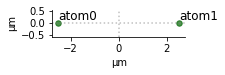

In [2]:
duration = 200
R = 5

pi = Pulse(BlackmanWaveform(duration,np.pi/(1000)),ConstantWaveform(duration,0),0)
twopi = Pulse(BlackmanWaveform(duration,2*np.pi/(1000)),ConstantWaveform(duration,0),0)
threepi = Pulse(BlackmanWaveform(duration,3*np.pi/(1000)),ConstantWaveform(duration,0),0)

# Atom Register and Device
L = 2
reg = Register.rectangle(1, L, spacing=R, prefix='atom')
device = Chadoq2(reg) 
reg.draw()

In [3]:
# Prepare state:
def prepare(seq,state_id):
    if state_id=='hh':  # 00
        seq.declare_channel('raman', 'raman_local') # For preparing state
        seq.target('atom0', 'raman')
        seq.add(pi, 'raman')
        seq.target('atom1', 'raman')
        seq.add(threepi, 'raman','wait-for-all')
    elif state_id=='gh':  # 01
        seq.declare_channel('raman', 'raman_local') # For preparing state
        seq.target('atom1', 'raman')
        seq.add(pi, 'raman')
    elif state_id=='hg':  # 10
        seq.declare_channel('raman', 'raman_local') # For preparing state
        seq.target('atom0', 'raman')
        seq.add(pi, 'raman')
    elif state_id=='gg':  # 11
        return None
    else:
        raise ValueError('No state corresponds')

In [4]:
def prep_state(state):
    # Define sequence and Set channels
    seq = Sequence(device)
    # Prepare state:
    prepare(seq, state)
    seq.draw()
    return seq

In [6]:
def CZ_gate(in_state):
    # Define sequence and Set channels
    seq = Sequence(device)
    
    seq.declare_channel('rydberg', 'rydberg_local') #Atom 0 will be control

    # Prepare state:
    prepare(seq, in_state)
    
    # Write CZ sequence:
    seq.target('atom0','rydberg')
    seq.add(pi, 'rydberg','wait-for-all') 
    seq.target('atom1','rydberg')
    seq.add(twopi, 'rydberg')
    seq.target('atom0','rydberg')
    seq.add(pi, 'rydberg') 

    seq.draw()
    return seq
    

In [7]:
states3 = {
    'gg' : qutip.tensor([qutip.basis(3,1),qutip.basis(3,1)]),
    'hg' : qutip.tensor([qutip.basis(3,2),qutip.basis(3,1)]),
    'gh' : qutip.tensor([qutip.basis(3,1),qutip.basis(3,2)]),
    'hh' : qutip.tensor([qutip.basis(3,2),qutip.basis(3,2)])
}

states2 = {
    'gg' : qutip.tensor([qutip.basis(2,0),qutip.basis(2,0)]),
    'hg' : qutip.tensor([qutip.basis(2,1),qutip.basis(2,0)]),
    'gh' : qutip.tensor([qutip.basis(2,0),qutip.basis(2,1)]),
    'hh' : qutip.tensor([qutip.basis(2,1),qutip.basis(2,1)])
}

#full_state = 0.5 * (states['gg'] + states['hg'] + states['gh'] + states['hh'])
#target_state = 0.5 * (-states['gg'] - states['hg'] - states['gh'] + states['hh'])

# State Preparation

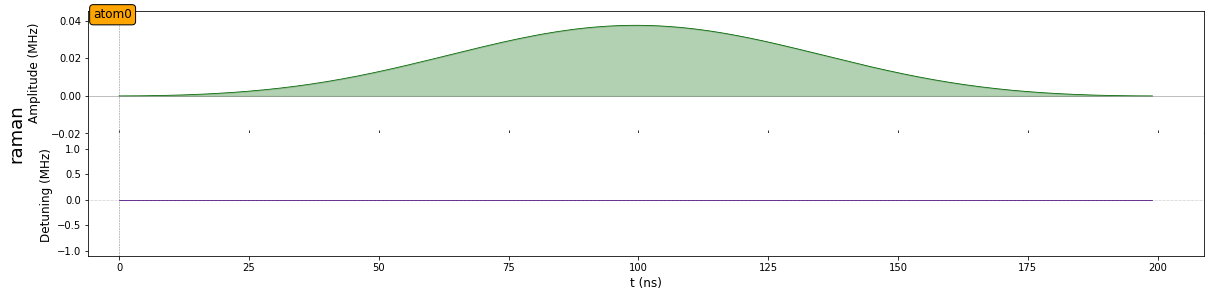

No observable provided. Calculating state evolution...


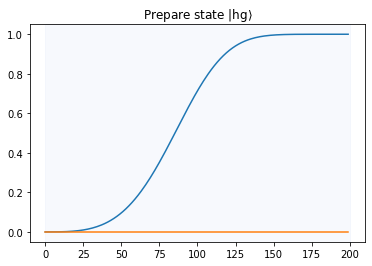

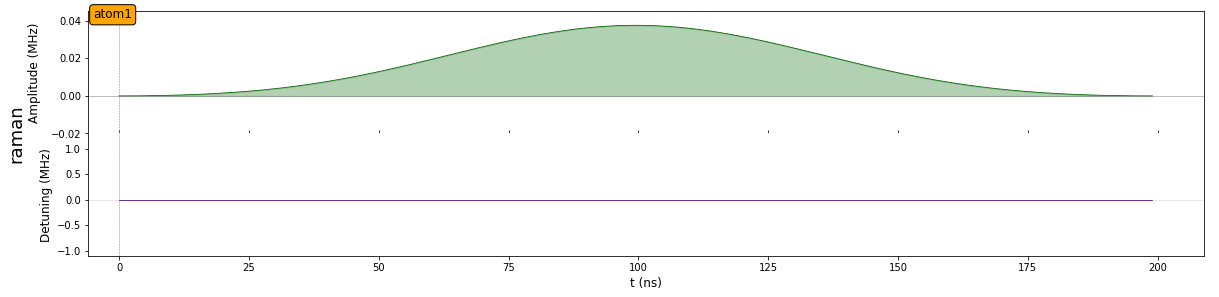

No observable provided. Calculating state evolution...


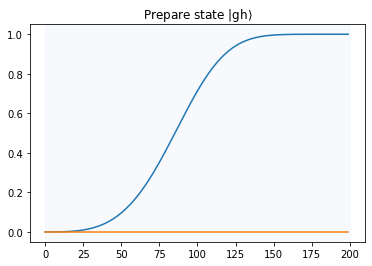

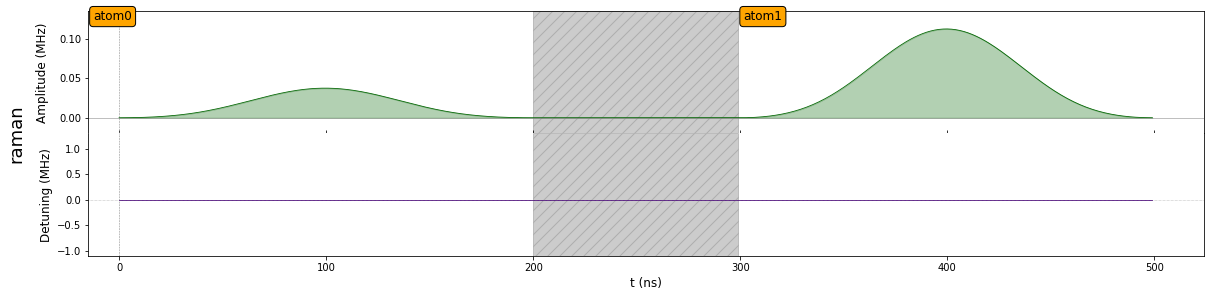

No observable provided. Calculating state evolution...


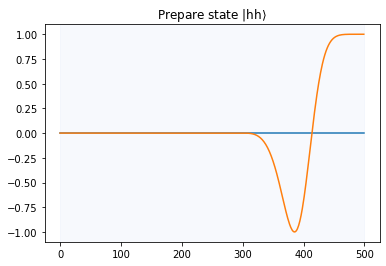

In [8]:
for state in ['hg','gh','hh']:
    seq = prep_state(state)
    simul = Simulation(seq)
    simul.run(initial_state = states2['gg'], all_states=True)

    data=[st.overlap(states2[state]) for st in simul.output]
    
    plt.plot(np.imag(data))
    plt.plot(np.real(data))
    plt.axvspan(0, state.count('h')*duration+ (state.count('h')//2)*100, alpha=0.04, color='royalblue')
    plt.title(fr"Prepare state $|${state}$\rangle$")

# Application of CZ sequence

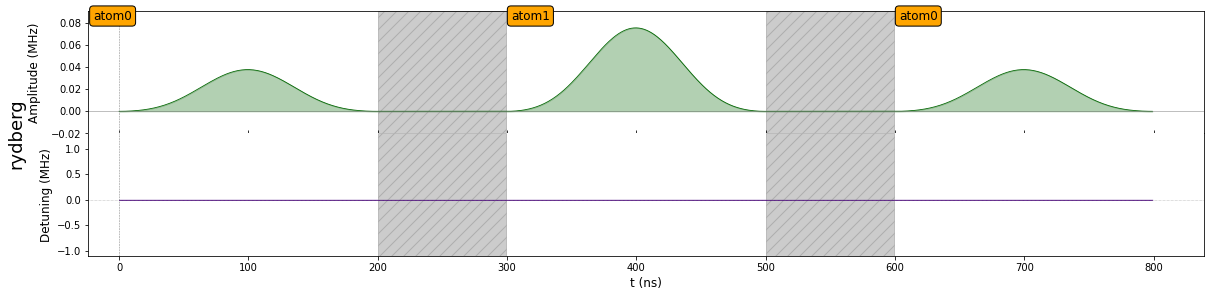

No observable provided. Calculating state evolution...
(-0.999999969997136+0.0002129698554780278j)


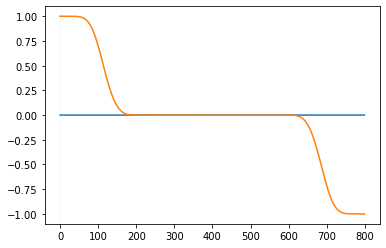

In [9]:
in_state = 'gg'
seq = CZ_gate(in_state)
simul = Simulation(seq)
simul.run(initial_state = states2['hh'], all_states=True) # actually states2['hh'] = |gg> in g-r basis

data=[]
for state in simul.output:
    res = state.overlap(states2['hh'])
    data.append(res)

print(data[-1])

plt.plot(np.imag(data))
plt.plot(np.real(data))
plt.axvspan(0, in_state.count('h')*duration+ (in_state.count('h')//2)*100, alpha=0.04, color='royalblue')
#plt.title(fr"Initial state is $|${in_state}$ \rangle$")

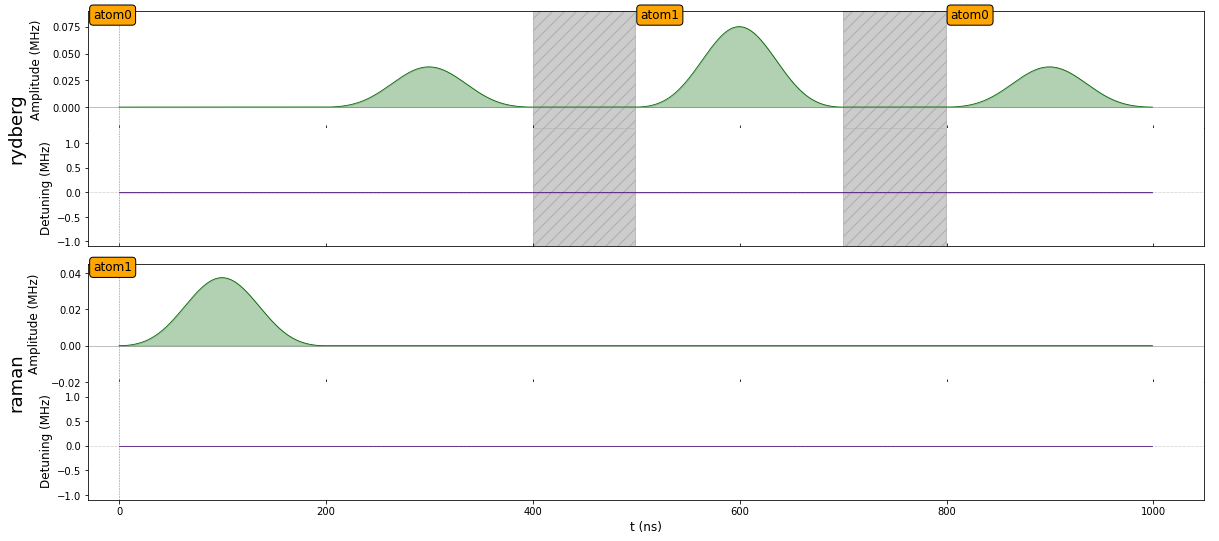

No observable provided. Calculating state evolution...
(1.2310639056685418e-197-0.9999999850358964j)


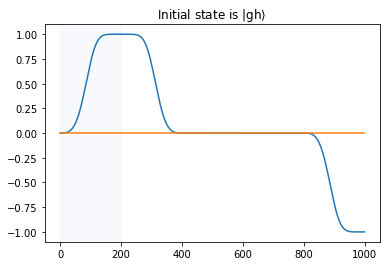

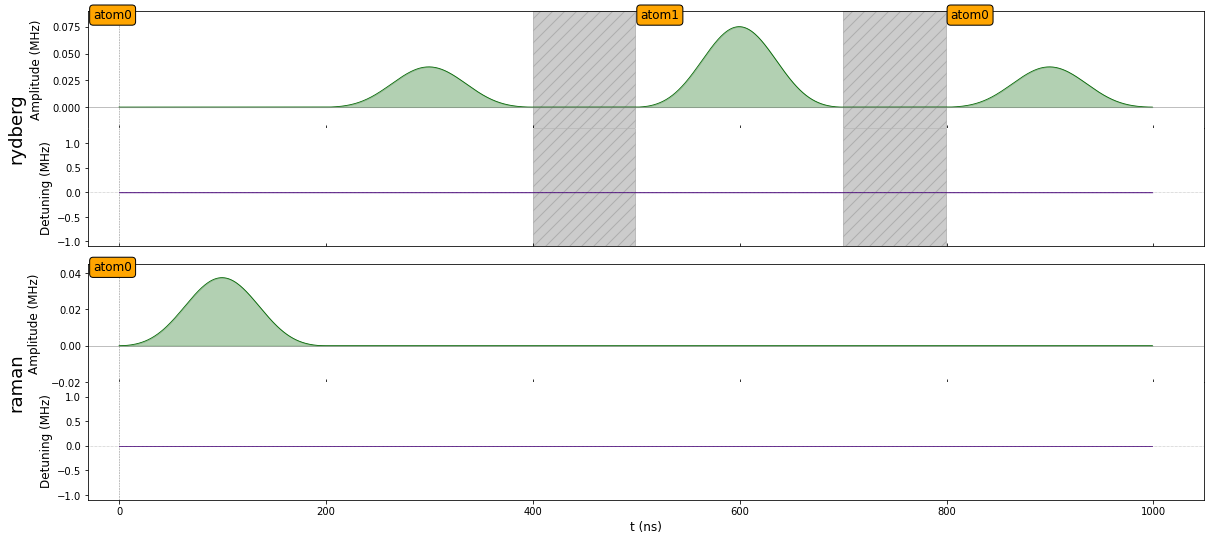

No observable provided. Calculating state evolution...
(1.569987171900936e-38-0.9999999850358997j)


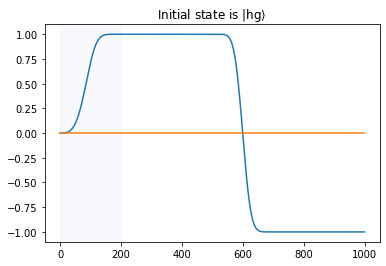

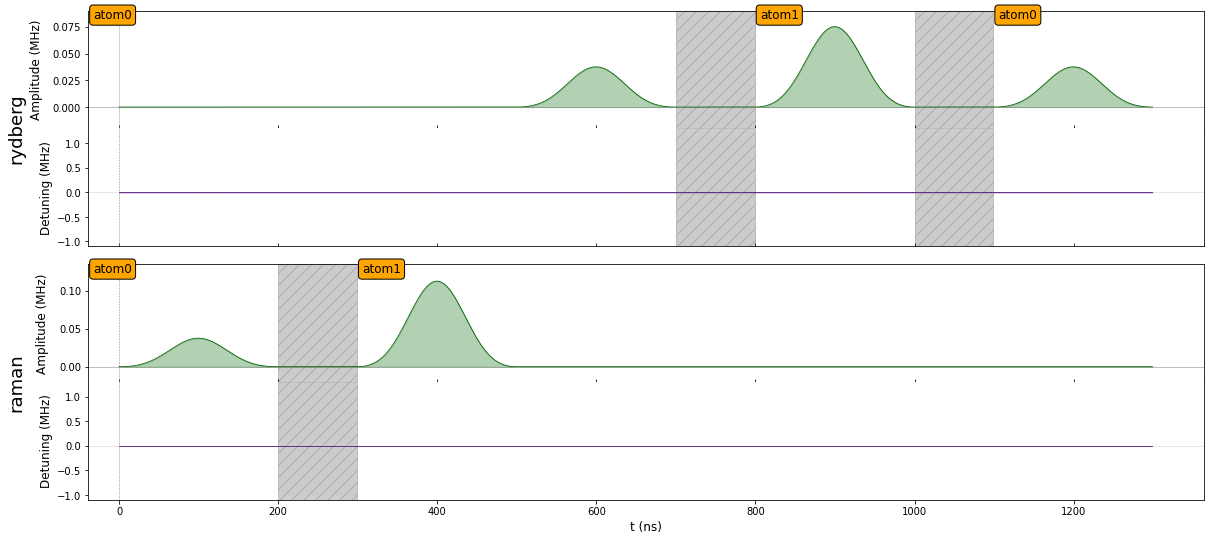

No observable provided. Calculating state evolution...
(0.9999999848338704+0j)


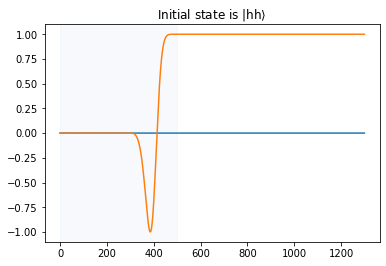

In [10]:
for in_state in ['gh','hg','hh']:
    seq = CZ_gate(in_state)
    simul = Simulation(seq)
    simul.run(initial_state = states3['gg'], all_states=True)

    data=[]
    for state in simul.output:
        res = state.overlap(states3[in_state])
        data.append(res)

    print(data[-1])
    
    plt.plot(np.imag(data))
    plt.plot(np.real(data))
    plt.axvspan(0, in_state.count('h')*duration+ (in_state.count('h')//2)*100, alpha=0.04, color='royalblue')
    plt.title(fr"Initial state is $|${in_state}$\rangle$")